## Deep Learning Tutorial 
### Day 4. CIFAR10 Classification

## Imports

In [1]:
from glob import glob
from time import time
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
try:
    from urllib.request import urlretrieve
except:
    from urllib import urlretrieve
import pandas as pd
import numpy as np
import sys, os, math
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import itertools
import tarfile
import pickle

print ("Packages loaded")

C:\Users\admin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Packages loaded


## Set parameters

In [2]:
# PARAMS
_BATCH_SIZE = 32
_EPOCH = 10
_SNAPSHOT_PREFIX = "cifar10"
_NUM_VIS_EMBEDDING = 500
_IMAGE_HEIGHT = 32
_IMAGE_WIDTH = 32
_IMAGE_CHANNELS = 3
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
_NUM_CLASSES = len(class_names)
class_to_num = dict(zip(class_names, range(_NUM_CLASSES)))
num_to_class = dict(zip(range(_NUM_CLASSES), class_names))
lr = 1e-3

In [3]:
tf.__version__

'1.10.0'

In [4]:
def get_data_set(name="train"):
    x = y = None
    maybe_download_and_extract()
    folder_name = "cifar10"
    f = open('../data/'+folder_name+'/batches.meta', 'rb')
    f.close()

    if name is "train":
        for i in range(5):
            f = open('../data/'+folder_name+'/data_batch_' + str(i + 1), 'rb')
            try:
                datadict = pickle.load(f, encoding='latin1') 
            except:
                datadict = pickle.load(f)
            f.close()

            _X = datadict["data"]
            _Y = datadict['labels']

            _X = np.array(_X, dtype=float) / 255.0
            _X = _X.reshape([-1, _IMAGE_CHANNELS, _IMAGE_HEIGHT, _IMAGE_WIDTH])
            _X = _X.transpose([0, 2, 3, 1])
            _X = _X.reshape(-1, _IMAGE_HEIGHT*_IMAGE_WIDTH*_IMAGE_CHANNELS)

            if x is None:
                x = _X
                y = _Y
            else:
                x = np.concatenate((x, _X), axis=0)
                y = np.concatenate((y, _Y), axis=0)

    elif name is "test":
        f = open('./data/'+folder_name+'/test_batch', 'rb')
        try:
            datadict = pickle.load(f, encoding='latin1') 
        except:
            datadict = pickle.load(f)
        f.close()
        x = datadict["data"]
        y = np.array(datadict['labels'])
        x = np.array(x, dtype=float) / 255.0
        x = x.reshape([-1, _IMAGE_CHANNELS, _IMAGE_HEIGHT, _IMAGE_WIDTH])
        x = x.transpose([0, 2, 3, 1])
        x = x.reshape(-1, _IMAGE_HEIGHT*_IMAGE_WIDTH*_IMAGE_CHANNELS)

    return x, dense_to_one_hot(y)

def dense_to_one_hot(labels_dense, num_classes=10):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

def print_download_progress(count, block_size, total_size):
    pct_complete = float(count * block_size) / total_size
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()
    
def maybe_download_and_extract():
    main_directory = "../data/"
    if not os.path.exists(main_directory):
        os.makedirs(main_directory)
    cifar_10_directory = main_directory+"cifar10/"
    if not os.path.exists(cifar_10_directory):
        url = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
        filename = url.split('/')[-1]
        file_path = os.path.join(main_directory, filename)
        zip_cifar_10 = file_path
        file_path, _ = urlretrieve(url=url, filename=file_path, 
                                   reporthook=print_download_progress)

        print()
        print("Download finished. Extracting files.")
        if file_path.endswith(".zip"):
            zipfile.ZipFile(file=file_path, mode="r").extractall(main_directory)
        elif file_path.endswith((".tar.gz", ".tgz")):
            tarfile.open(name=file_path, mode="r:gz").extractall(main_directory)
        print("Done.")

        os.rename(main_directory+"cifar-10-batches-py", cifar_10_directory)
        os.remove(zip_cifar_10)

In [5]:
train_x, train_y = get_data_set("train")
test_x, test_y = get_data_set("test")

print ("Dataset loaded")

- Download progress: 100.0%
Download finished. Extracting files.
Done.
Dataset loaded


(50000, 3072)
(50000, 10)


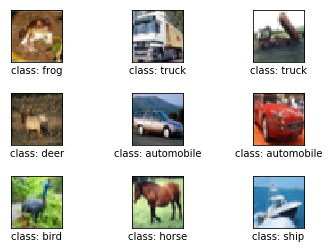

In [6]:
def show_images():
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.6, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(train_x[i].reshape(_IMAGE_HEIGHT, _IMAGE_WIDTH, _IMAGE_CHANNELS))
        
        # Name of the true class.
        cls_true_name = num_to_class[train_y[i].argmax()]
        xlabel = "class: {0}".format(cls_true_name)
        
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    return

print(train_x.shape)
print(train_y.shape)
show_images()

In [7]:
x = tf.placeholder(tf.float32, shape=[None, _IMAGE_HEIGHT * _IMAGE_WIDTH * _IMAGE_CHANNELS], name='Input')

In [8]:
y_true = tf.placeholder(tf.float32, shape=[None, _NUM_CLASSES], name='Output')

In [9]:
keep_probability = tf.placeholder(tf.float32, shape=[], name='keep_prob')

In [10]:
global_step = tf.Variable(initial_value=0, trainable=False, name='global_step')

In [11]:
x_image = tf.reshape(x, [-1, _IMAGE_HEIGHT, _IMAGE_WIDTH, _IMAGE_CHANNELS], name='images')

In [12]:
### [Exercise 1] Change the CNN architecture to VGG16
feat = slim.repeat(x_image, 2, slim.conv2d, 32, [3, 3], scope='conv1')
feat = slim.max_pool2d(feat, [2, 2], padding='SAME', scope='pool1')
feat = slim.repeat(feat, 1, slim.conv2d, 64, [3, 3], scope='conv2')
feat = slim.max_pool2d(feat, [2, 2], padding='SAME', scope='pool2')
feat = slim.repeat(feat, 1, slim.conv2d, 128, [3, 3], scope='conv3')
feat = slim.max_pool2d(feat, [2, 2], padding='SAME', scope='pool3')
feat = slim.flatten(feat, scope='flatten')
feat = slim.fully_connected(feat, 1000, scope='fully_connected')

# with tf.variable_scope("vgg_16") :
#     feat = slim.repeat(x_image, 2, slim.conv2d, 64, [3, 3], scope='conv1')
#     feat = slim.max_pool2d(feat, [2, 2], padding='SAME', scope='pool1')
#     feat = slim.repeat(feat, 2, slim.conv2d, 128, [3, 3], scope='conv2')
#     feat = slim.max_pool2d(feat, [2, 2], padding='SAME', scope='pool2')
#     feat = slim.repeat(feat, 3, slim.conv2d, 256, [3, 3], scope='conv3')
#     feat = slim.max_pool2d(feat, [2, 2], padding='SAME', scope='pool3')
# #     feat = slim.repeat(feat, 3, slim.conv2d, 512, [3, 3], scope='conv4')
# #     feat = slim.max_pool2d(feat, [2, 2], padding='SAME', scope='pool4')   # max pool 많을때 cifar는 더 성능이 떨어진다.
# #     feat = slim.repeat(feat, 3, slim.conv2d, 512, [3, 3], scope='conv5')
# #     feat = slim.max_pool2d(feat, [2, 2], padding='SAME', scope='pool4')
# feat = slim.flatten(feat, scope='flatten')
# feat = slim.fully_connected(feat, 1000, scope='fully_connected')

In [13]:
### [Exercise 2] Add a regularization method
# feat = slim.batch_norm(feat scope="batch_norm")
feat = slim.dropout(feat, keep_prob=keep_probability, scope='dropout')

In [14]:
y_pred = slim.fully_connected(feat, _NUM_CLASSES, scope='feat', activation_fn=None)
softmax = tf.nn.softmax(y_pred)
y_pred_cls = tf.argmax(softmax, axis=1)

In [15]:
print(tf.global_variables())

[<tf.Variable 'global_step:0' shape=() dtype=int32_ref>, <tf.Variable 'conv1/conv1_1/weights:0' shape=(3, 3, 3, 32) dtype=float32_ref>, <tf.Variable 'conv1/conv1_1/biases:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'conv1/conv1_2/weights:0' shape=(3, 3, 32, 32) dtype=float32_ref>, <tf.Variable 'conv1/conv1_2/biases:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'conv2/conv2_1/weights:0' shape=(3, 3, 32, 64) dtype=float32_ref>, <tf.Variable 'conv2/conv2_1/biases:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'conv3/conv3_1/weights:0' shape=(3, 3, 64, 128) dtype=float32_ref>, <tf.Variable 'conv3/conv3_1/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'fully_connected/weights:0' shape=(2048, 1000) dtype=float32_ref>, <tf.Variable 'fully_connected/biases:0' shape=(1000,) dtype=float32_ref>, <tf.Variable 'feat/weights:0' shape=(1000, 10) dtype=float32_ref>, <tf.Variable 'feat/biases:0' shape=(10,) dtype=float32_ref>]


In [16]:
print(tf.trainable_variables())

[<tf.Variable 'conv1/conv1_1/weights:0' shape=(3, 3, 3, 32) dtype=float32_ref>, <tf.Variable 'conv1/conv1_1/biases:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'conv1/conv1_2/weights:0' shape=(3, 3, 32, 32) dtype=float32_ref>, <tf.Variable 'conv1/conv1_2/biases:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'conv2/conv2_1/weights:0' shape=(3, 3, 32, 64) dtype=float32_ref>, <tf.Variable 'conv2/conv2_1/biases:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'conv3/conv3_1/weights:0' shape=(3, 3, 64, 128) dtype=float32_ref>, <tf.Variable 'conv3/conv3_1/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'fully_connected/weights:0' shape=(2048, 1000) dtype=float32_ref>, <tf.Variable 'fully_connected/biases:0' shape=(1000,) dtype=float32_ref>, <tf.Variable 'feat/weights:0' shape=(1000, 10) dtype=float32_ref>, <tf.Variable 'feat/biases:0' shape=(10,) dtype=float32_ref>]


In [17]:
try:
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y_true)
except:
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true)

In [18]:
loss = tf.reduce_mean(cross_entropy)

In [ ]:
# tensor board 사용 하기 위하여 추가.
loss_summary = tf.summary.scalar('loss', loss)

In [20]:
global_accuracy = 0
epoch_start = 0

### [Exercise 3] Write your own optimizer
# optimizer =  tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss) 
optimizer = tf.train.AdamOptimizer(learning_rate=lr,
                                   beta1=0.9,
                                   beta2=0.999,
                                   epsilon=1e-08).minimize(loss, global_step=global_step)

In [21]:
correct_prediction = tf.equal(y_pred_cls, tf.argmax(y_true, axis=1))

In [22]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))*100.0

In [23]:
sess = tf.Session()

In [24]:
sess.run(tf.global_variables_initializer())
print("Initialized variables.")

Initialized variables.


In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print('Drawing confusion matrix...')
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [26]:
def plot_tsne(y_pred_val, y_true_val):
    numbered = LabelEncoder().fit_transform(list(y_true_val))
    c = plt.cm.get_cmap('hsv', len(set(numbered)))
    colors=[]
    for num in numbered:
        temp=c(num)
        colors.append(temp)
        
    print('Fitting TSNE...')
    X_embedded = TSNE(n_components=2).fit_transform(y_pred_val[:10000])
    X_embedded = np.array(X_embedded)
    vis_x = X_embedded[:, 0]
    vis_y = X_embedded[:, 1]
    numbered = LabelEncoder().fit_transform(list(y_true_val))
    c = plt.cm.get_cmap('hsv', len(set(numbered)))
    plt.figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(vis_x, vis_y, c=colors,alpha=1,linewidths=1,s=10, edgecolors='none')
    plt.show()
    return X_embedded

In [27]:
def test(_global_step, epoch, y_pred_val, y_true_val):
    global global_accuracy
    global epoch_start

    i = 0
    predicted_class = np.zeros(shape=len(test_x), dtype=np.int)
    while i < len(test_x):
        j = min(i + _BATCH_SIZE, len(test_x))
        batch_xs = test_x[i:j, :]
        batch_ys = test_y[i:j, :]
        predicted_class[i:j] = sess.run(
            y_pred_cls,
            feed_dict={x: batch_xs, y_true: batch_ys, keep_probability: 1.0}
        )    
        i = j
    text_y_argmax = np.argmax(test_y, axis=1)  
    correct = (text_y_argmax == predicted_class)
    acc = correct.mean()*100
    correct_numbers = correct.sum()

    hours, rem = divmod(time() - epoch_start, 3600)
    minutes, seconds = divmod(rem, 60)
    mes = "\nEpoch {} - accuracy: {:.1f}% ({}/{}) - time: {:0>2}:{:0>2}:{:05.2f}"
    print(mes.format((epoch+1), acc, correct_numbers, len(test_x), int(hours), int(minutes), seconds))

    if global_accuracy != 0 and global_accuracy < acc:
        mes = "This epoch receive better accuracy: {:.1f}% > {:.1f}%."
        print(mes.format(acc, global_accuracy))
        global_accuracy = acc

    elif global_accuracy == 0:
        global_accuracy = acc
        
    # Plot non-normalized confusion matrix
    cnf_matrix = confusion_matrix(text_y_argmax, predicted_class)
    np.set_printoptions(precision=2)
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')
    plot_tsne(y_pred_val, y_true_val)
    
    print("###########################################################################################################")

In [28]:
def train(epoch):
    global epoch_start
    epoch_start = time()
    batch_size = int(math.ceil(len(train_x) / _BATCH_SIZE))
    i_global = 0

    for s in range(batch_size):
        batch_xs = train_x[s*_BATCH_SIZE: (s+1)*_BATCH_SIZE]
        batch_ys = train_y[s*_BATCH_SIZE: (s+1)*_BATCH_SIZE]

        start_time = time()
        i_global, _, batch_loss, batch_acc = sess.run(
            [global_step, optimizer, loss, accuracy],
            feed_dict={x: batch_xs, y_true: batch_ys, keep_probability: 0.5})
        duration = time() - start_time

        if s % 100 == 0:
            
            ## Tensorboard 때문에 추가
            summary_eval = sess.run(tf_summary_op, feed_dict={x: batch_xs, y_true: batch_ys, keep_probability:1.0})
            wirter.add_summary(summary_eval, s)
            ##########################################################
            
            percentage = int(float(s)/float(batch_size)*100.0)
            bar_len = 29
            filled_len = int((bar_len*int(percentage))/100)
            bar = '=' * filled_len + '>' + '-' * (bar_len - filled_len)

            msg = "Global step: {:>5} - [{}] {:>3}% - accuracy: {:.1f}% - loss: {:.4f} - {:.1f} sample/sec"
            print(msg.format(i_global, bar, percentage, batch_acc, batch_loss, _BATCH_SIZE / duration))
    y_pred_val = sess.run(y_pred, feed_dict={x: train_x[:_NUM_VIS_EMBEDDING], keep_probability: 1.0})
    y_true_val = train_y[:_NUM_VIS_EMBEDDING]
    y_true_val = y_true_val.argmax(1)

    test(i_global, epoch, y_pred_val, y_true_val)

In [ ]:
# Tensorboard 때문에 추가
tf_summary_op = tf.summay.merge_all()
tensorboard_path = './tensorboard'

if not os.path.exists(tensorboard_path):
    os.mkdir(tensorboard_path)

writer = tf.summary.FileWriter(tensorboard_path, sess.graph)

Start training

Epoch: 1/10

Global step:     1 - [>-----------------------------]   0% - accuracy: 9.4% - loss: 2.3366 - 16.2 sample/sec
Global step:   101 - [=>----------------------------]   6% - accuracy: 34.4% - loss: 2.1093 - 31.5 sample/sec
Global step:   201 - [===>--------------------------]  12% - accuracy: 25.0% - loss: 1.6467 - 33.4 sample/sec
Global step:   301 - [=====>------------------------]  19% - accuracy: 28.1% - loss: 1.7452 - 35.3 sample/sec
Global step:   401 - [=======>----------------------]  25% - accuracy: 43.8% - loss: 1.3332 - 33.0 sample/sec
Global step:   501 - [========>---------------------]  31% - accuracy: 43.8% - loss: 1.5234 - 42.1 sample/sec
Global step:   601 - [===========>------------------]  38% - accuracy: 53.1% - loss: 1.4015 - 30.4 sample/sec
Global step:   701 - [============>-----------------]  44% - accuracy: 50.0% - loss: 1.4769 - 28.2 sample/sec
Global step:   801 - [==============>---------------]  51% - accuracy: 62.5% - loss: 1.1157 

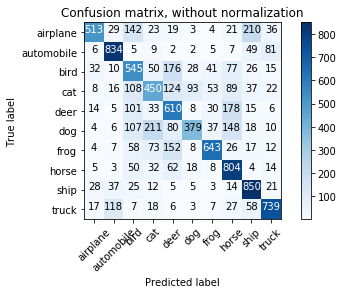

Fitting TSNE...


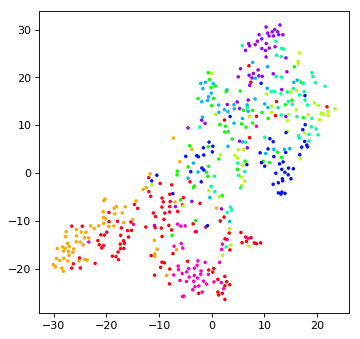

###########################################################################################################

Epoch: 2/10

Global step:  1564 - [>-----------------------------]   0% - accuracy: 65.6% - loss: 1.0333 - 27.3 sample/sec
Global step:  1664 - [=>----------------------------]   6% - accuracy: 59.4% - loss: 1.3085 - 30.6 sample/sec
Global step:  1764 - [===>--------------------------]  12% - accuracy: 59.4% - loss: 0.9328 - 40.8 sample/sec
Global step:  1864 - [=====>------------------------]  19% - accuracy: 78.1% - loss: 0.8043 - 33.3 sample/sec
Global step:  1964 - [=======>----------------------]  25% - accuracy: 68.8% - loss: 0.8439 - 34.3 sample/sec
Global step:  2064 - [========>---------------------]  31% - accuracy: 71.9% - loss: 0.8773 - 31.2 sample/sec
Global step:  2164 - [===========>------------------]  38% - accuracy: 65.6% - loss: 1.0309 - 28.2 sample/sec
Global step:  2264 - [============>-----------------]  44% - accuracy: 50.0% - loss: 1.2055 - 33.6 sample/se

KeyboardInterrupt: 

In [29]:
print("Start training")
train_start = time()

for i in range(_EPOCH):
    print("\nEpoch: {}/{}\n".format((i+1), _EPOCH))
    train(i)

hours, rem = divmod(time() - train_start, 3600)
minutes, seconds = divmod(rem, 60)
mes = "Best accuracy pre session: {:.2f}%, time: {:0>2}:{:0>2}:{:05.2f}"
print(mes.format(global_accuracy, int(hours), int(minutes), seconds))
print("Done training")